In [113]:
# The aim of this python script is to provide a cmprehensible multibody formulation of wind turbines
# for structural dynamic simulations. The multibody formulation is based on the Kane's method.

# SymPy is a Python library for symbolic mathematics.
# It aims to become a full-featured computer algebra system (CAS) while keeping the code as simple as possible
# in order to be comprehensible and easily extensible. SymPy is written entirely in Python.
# Copyright © 2023 SymPy Development Team.

# Author: Dr.Ing. Feng Guo (郭峰) 
# Contacts: fengguokm@sjtu.edu.cn
# licensed under the Apache License 2.0.

# This code is published as the attachment of this publication:
# TorqTwin—An open-source reference multibody modeling framework for wind turbine structural dynamics
# Feng Guo^a,Zhen Gao^a, David Schlipf^b,c
# State Key Laboratory of Ocean Engineering, Shanghai Jiao Tong University, 800 Dongchuan Road, Shanghai, China
# Wind Energy Technology Institute, Flensburg University of Applied Sciences, Kanzleistraße 91-93, 24943 Flensburg, Germany
# sowento GmbH, Hessenlauweg 14, 70569 Stuttgart, Germany
# https://doi.org/10.1016/j.renene.2024.121268

#This code is mainly for educational purposes.
#This example aims for readers to reproduce the results of Figure 7 in the paper.

In [114]:
import numpy as np
import scipy.io as sio
from scipy.interpolate import interp1d
import sympy as sm
import sympy.physics.mechanics as me


#-------------------Read Some Input Data------------------
BladeData  = sio.loadmat('EigenAnalysisResults\IEA15MWblade.mat')   # blade cross-section mass properities
ShapeFunc  = sio.loadmat('EigenAnalysisResults\IEA15MWbladeModeShape.mat')  # pre-calculated mode shape functions
GenStiff   = sio.loadmat('EigenAnalysisResults\IEA15MWbladeGeneStiff.mat')  # pre-calculated generalized stifiness matrix

In [115]:
Dist2RootZ          =  BladeData['Blade']['Dist2RootZ'][0][0][0]       # distance from cross-sections to blade root
MassCinRoot_x       =  BladeData['Blade']['MassCinRoot_x'][0][0][0]    # the x coordinate of mass center of current cross-section in blade root coordinate system
MassCinRoot_y       =  BladeData['Blade']['MassCinRoot_y'][0][0][0]    # the x coordinate of mass center of current cross-section in blade root coordinate system
theta_m             =  BladeData['Blade']['theta_m'][0][0][0];         # mass axis orientation relative to blade root coordinate system
Iner_x              =  BladeData['Blade']['Iner_x'][0][0][0];          # inertia about the x mass-axis 
Iner_y              =  BladeData['Blade']['Iner_y'][0][0][0];          # inertia about the y mass-axis 
Iner_z              =  BladeData['Blade']['Iner_z'][0][0][0];          # inertia about the z mass-axis 
dMass               =  BladeData['Blade']['dm'][0][0][0];              # mass per unit length

# some parameters
Nmode               = 20
NumBl               = 1


RotorSpeed          = 0.20944  #[radps]
ConsiderRotation    = 0
Kp = GenStiff['Kp'][0:Nmode,0:Nmode]  # generalized stiffness coordinate system

In [116]:

Kp.size

400

In [117]:
# calculate the body mass and inertia
Body_z          = np.zeros([len(Dist2RootZ)-1])
Body_x          = np.zeros([len(Dist2RootZ)-1])
Body_y          = np.zeros([len(Dist2RootZ)-1])
Body_theta_m    = np.zeros([len(Dist2RootZ)-1])
Body_Ixx        = np.zeros([len(Dist2RootZ)-1])
Body_Iyy        = np.zeros([len(Dist2RootZ)-1])
Body_Izz        = np.zeros([len(Dist2RootZ)-1])
Body_mass       = np.zeros([len(Dist2RootZ)-1])


BldElem         = len(Dist2RootZ)-1

for i in range(BldElem):
    Body_z[i]          = np.squeeze(0.5*(Dist2RootZ[i]+Dist2RootZ[i+1]))
    Body_x[i]          = np.squeeze(0.5*(MassCinRoot_x[i]+MassCinRoot_x[i+1]))
    Body_y[i]          = np.squeeze(0.5*(MassCinRoot_y[i]+MassCinRoot_y[i+1]))

    body_length        = np.sqrt((Dist2RootZ[i+1]-Dist2RootZ[i])**2+(MassCinRoot_x[i+1]-MassCinRoot_x[i])**2+(MassCinRoot_y[i+1]-MassCinRoot_y[i])**2)
    Body_mass[i]       = np.squeeze(0.5*body_length*(dMass[i]+dMass[i+1]))
    Body_theta_m[i]    = np.squeeze(0.5*(theta_m[i]+theta_m[i+1]))
    Body_Ixx[i]        = np.squeeze(0.5*body_length*(Iner_x[i]+Iner_x[i+1]))
    Body_Iyy[i]        = np.squeeze(0.5*body_length*(Iner_y[i]+Iner_y[i+1]))
    Body_Izz[i]        = np.squeeze(0.5*body_length*(Iner_z[i]+Iner_z[i+1]));


In [118]:
# Configurate DOFs
GenCoord = []
GenSpeed = []
GenAcc = []
ACCtoReplace = []
StoReplace = []

t = me.dynamicsymbols._t

if ConsiderRotation:
   TotalDOF = Nmode+1
else:
   TotalDOF = Nmode

for i in range(TotalDOF):    # last DOF for the rotational speed, the rest for Modal reduction   
    GenCoord.append(me.dynamicsymbols('q' + str(i + 1)))
    # GenSpeed.append(me.dynamicsymbols('u' + str(i + 1)))
    GenSpeed.append(GenCoord[i].diff(t))
    GenAcc.append(me.dynamicsymbols('a' + str(i + 1)))
    StoReplace.append(GenCoord[i].diff(t, 1))
    ACCtoReplace.append(GenCoord[i].diff(t, 2))

qdot2_repl = dict(zip(ACCtoReplace, GenAcc))

In [119]:
# set up frame and points 

GlobalFrame = me.ReferenceFrame('G') 
GlobalOrigin= me.Point('Go')  #
TiltFrame   = me.ReferenceFrame('TLT')  # tilted shaft coordinate system
ApexPoint   = me.Point('TLTo')  #

HubFrame    = me.ReferenceFrame('H')  # also the low-speed shaft
HubPoint    = me.Point('Ho')


BldConeFrame = []
BldConePoint = []
BldRootFrame = []
BldRootPoint = []



BladeFrame = [0] * int(NumBl)
BladePoint = [0] * int(NumBl)

for j in range(int(NumBl)):
    
    BldConeFrame.append(me.ReferenceFrame('BC' + str(j + 1)))
    BldConePoint.append(me.Point('BC' + str(j + 1) + 'o'))
    BldRootFrame.append(me.ReferenceFrame('BR' + str(j + 1)))
    BldRootPoint.append(me.Point('BR' + str(j + 1) + 'o'))
    BladeFrame[j] = []
    BladePoint[j] = []

    for i in range(BldElem):
        BladeFrame[j].append(me.ReferenceFrame('B' + str(j + 1) + 'E' + str(i + 1)))
        BladePoint[j].append(me.Point('B' + str(j + 1) + 'Eo' + str(i + 1)))

In [120]:
ShftTilt = 0


TiltFrame.orient_axis(GlobalFrame, -ShftTilt * np.deg2rad(1), GlobalFrame.y)
# tilted shaft, note that the angle is defined negative if rotor tilts up

ApexPoint.set_pos(GlobalOrigin, 0)
ApexPoint.set_vel(GlobalFrame, 0)

if ConsiderRotation:
    HubFrame.orient_axis(TiltFrame, GenCoord[-1], TiltFrame.x)    #GenCoord[-1]
else:
    HubFrame.orient_axis(TiltFrame, 0, TiltFrame.x)    #GenCoord[-1]
    

HubPoint.set_pos(ApexPoint, HubCm * TiltFrame.x)
HubPoint.set_vel(GlobalFrame, 0)


In [121]:
HubRadius = 3.97
PreCone   = 0      # one need to change the orientation in Beamdyn driver to allow non-zero cone

beta = [0, 0, 0]

for j in range(int(NumBl)):
    BldConeFrame[j].orient_body_fixed(HubFrame, (j * 2 / 3 * np.pi, PreCone * np.deg2rad(1), 0),
                                      'xyz')  # blade1 cone
    BldConePoint[j].set_pos(ApexPoint, HubRadius * BldConeFrame[j].z)
    BldConePoint[j].set_vel(HubFrame, 0)
    BldConePoint[j].v1pt_theory(HubPoint, GlobalFrame, HubFrame)
    BldRootFrame[j].orient_axis(BldConeFrame[j], beta[j], BldConeFrame[j].z)
    BldRootPoint[j].set_pos(BldConePoint[j], 0)
    BldRootPoint[j].set_vel(HubFrame, 0)  # assume the root is stiffly connected to hub
    BldRootPoint[j].v1pt_theory(HubPoint, GlobalFrame, HubFrame)

In [122]:

# blade elemments
for i in range(BldElem):  # Parameters.Blade.BldNodes):
    for j in range(int(NumBl)):
        dx = 0.0
        dy = 0.0
        dz = 0.0
        rx_dt = 0.0
        ry_dt = 0.0
        rz_dt = 0.0
        for imode in range(Nmode):
            interp_func_dx = interp1d(Dist2RootZ, ShapeFunc['Phi_dx'][imode], kind='linear', fill_value='extrapolate')
            interp_func_dy = interp1d(Dist2RootZ, ShapeFunc['Phi_dy'][imode], kind='linear', fill_value='extrapolate')
            interp_func_dz = interp1d(Dist2RootZ, ShapeFunc['Phi_dz'][imode], kind='linear', fill_value='extrapolate')
            interp_func_rx = interp1d(Dist2RootZ, ShapeFunc['Phi_rx'][imode], kind='linear', fill_value='extrapolate')
            interp_func_ry = interp1d(Dist2RootZ, ShapeFunc['Phi_ry'][imode], kind='linear', fill_value='extrapolate')
            interp_func_rz = interp1d(Dist2RootZ, ShapeFunc['Phi_rz'][imode], kind='linear', fill_value='extrapolate')

            dx  =  dx +  float(interp_func_dx(Body_z[i]))*GenCoord[imode]
            dy  =  dy +  float(interp_func_dy(Body_z[i]))*GenCoord[imode]
            dz  =  dz +  float(interp_func_dz(Body_z[i]))*GenCoord[imode]

            rx_dt  =  rx_dt +  float(interp_func_rx(Body_z[i]))*GenCoord[imode].diff(t)
            ry_dt  =  ry_dt +  float(interp_func_ry(Body_z[i]))*GenCoord[imode].diff(t)
            rz_dt  =  rz_dt +  float(interp_func_rz(Body_z[i]))*GenCoord[imode].diff(t)

        BladeFrame[j][i].set_ang_vel(BldRootFrame[j], rx_dt * BldRootFrame[j].x + ry_dt * BldRootFrame[j].y + rz_dt * BldRootFrame[j].z)
        BladePoint[j][i].set_pos(BldRootPoint[j], (dx+float(Body_x[i]))* BldRootFrame[j].x + (dy+float(Body_y[i]))* BldRootFrame[j].y + (dz+float(Body_z[i])) * BldRootFrame[j].z)
        BladePoint[j][i].v1pt_theory(HubPoint, GlobalFrame, HubFrame)



In [123]:
# acceleration and partial velocities

BladeEle_acc       = [[0 for col in range(BldElem)] for col in range(int(NumBl))]
BladeEle_ang_acc   = [[0 for col in range(BldElem)] for col in range(int(NumBl))]
BladeEle_P_vel     = [[0 for col in range(BldElem)] for col in range(int(NumBl))]
BladeEle_P_ang_vel = [[0 for col in range(BldElem)] for col in range(int(NumBl))]

for i in range(BldElem):  # Parameters.Blade.BldNodes):
    for j in range(int(NumBl)):
        BladeEle_acc[j][i]     = BladePoint[j][i].acc(GlobalFrame).express(GlobalFrame).xreplace(qdot2_repl)
        BladeEle_ang_acc[j][i] = BladeFrame[j][i].ang_acc_in(GlobalFrame).express(GlobalFrame).xreplace(qdot2_repl)

        BladeEle_P_vel[j][i] = []
        BladeEle_P_ang_vel[j][i] = []

        for q in GenSpeed:
            BladeEle_P_vel[j][i].append(BladePoint[j][i].vel(GlobalFrame).diff(q, GlobalFrame).express(GlobalFrame))
            BladeEle_P_ang_vel[j][i].append(BladeFrame[j][i].ang_vel_in(GlobalFrame).diff(q, GlobalFrame).express(GlobalFrame))

In [124]:
## Numerify the system new method

MassAxisFrame = me.ReferenceFrame('M') 

Frs_bar    = []
Frs_bar_da = []
Frs_bar_a0 = []
a_zerod = {x: 0 for x in GenAcc}

for i in range(len(GenCoord)):
    
    Frs_bar_da.append([0] * len(GenCoord))

for k in range(len(GenCoord)):

    Frs  = 0
    Frs0 = 0 

    # firstly the blade contribution--------------------
    for i in range(BldElem):  

        
        masses = float(Body_mass[i])
        
        
        for j in range(int(NumBl)):


            MassAxisFrame.orient_axis(BldRootFrame[j], -Body_theta_m[i], BldRootFrame[j].z)  #
            inertias = float(Body_Ixx[i]) * me.outer(MassAxisFrame.x, MassAxisFrame.x) \
               + float(Body_Iyy[i]) * me.outer(MassAxisFrame.y, MassAxisFrame.y) \
               + float(Body_Izz[i]) * me.outer(MassAxisFrame.z, MassAxisFrame.z)

            inertias = inertias.express(GlobalFrame)
            
            vr = BladeEle_P_vel[j][i][k]
            Rs = -masses * BladeEle_acc[j][i]
            

            Frs0 += vr.dot(Rs).xreplace(a_zerod)

            
                
            # consider the inertia as well
            wr = BladeEle_P_ang_vel[j][i][k]
            Ts = -(BladeEle_ang_acc[j][i].dot(inertias) +
                    me.cross(BladeEle_ang_acc[j][i], inertias).dot(BladeEle_ang_acc[j][i]))
            #Frs += wr.dot(Ts)
  
            Frs0 += wr.dot(Ts).xreplace(a_zerod)

            if ConsiderRotation:
                for m in (k,Nmode):
                    Frs_bar_da[k][m]+=vr.dot(Rs).diff(GenAcc[m]).xreplace(a_zerod)
                    Frs_bar_da[k][m]+=wr.dot(Ts).diff(GenAcc[m]).xreplace(a_zerod)
            else:
                m = k
                Frs_bar_da[k][m]+=vr.dot(Rs).diff(GenAcc[m]).xreplace(a_zerod)
                Frs_bar_da[k][m]+=wr.dot(Ts).diff(GenAcc[m]).xreplace(a_zerod)
                

    Frs_bar_a0.append(Frs0)

In [125]:
#Frs_bar_a0

In [126]:
def create_same_shape_list(original_list):
    if isinstance(original_list, list):
        return [create_same_shape_list(item) for item in original_list]
    else:
        return None  # 
        
# numerify all the partial velocity and partial angular velocity
def Numerify(Partial):
    func    = sm.Matrix([0, 0, 0])
    func[0] = Partial.dot(GlobalFrame.x)
    func[1] = Partial.dot(GlobalFrame.y)
    func[2] = Partial.dot(GlobalFrame.z)

    return sm.lambdify((GenCoord, GenSpeed), [func], 'numpy')

BladeEle_P_vel_num = create_same_shape_list(BladeEle_P_vel)
BladeEle_P_ang_vel_num = create_same_shape_list(BladeEle_P_ang_vel)

for i in range(len(BladeEle_P_vel_num)):
    for j in range(len(BladeEle_P_vel_num[0])):
        for k in range(len(BladeEle_P_vel_num[0][0])):
            BladeEle_P_vel_num[i][j][k] = Numerify(BladeEle_P_vel[i][j][k])
            BladeEle_P_ang_vel_num[i][j][k] = Numerify(BladeEle_P_ang_vel[i][j][k])

In [127]:

M = sm.lambdify((GenCoord, GenSpeed), sm.Matrix(Frs_bar_da))
M0 = sm.lambdify((GenCoord, GenSpeed), sm.Matrix(Frs_bar_a0))

#M(q_vals, qdt_vals)
q_vals = np.zeros(len(GenCoord))
qdt_vals = np.zeros(len(GenCoord))

In [128]:
q_vals = np.zeros(len(GenCoord))
qdt_vals = np.zeros(len(GenCoord))

In [129]:
#Body_mass

In [130]:
def CalculateDerivative(dM,M0,Kp,q_vals, qdt_vals,NumBl,BldElem,Body_mass,GenCoord,ConsiderRotation,time):

    
    t              = time
    f0             = 10000
    Gravity        = 9.81 #9.81
    t1             = 2;      # 
    t2             = 10  #;    # 
    
    Fr_bar = np.array([[0] for i in range(len(GenCoord))])
    
    for k in range(len(GenCoord)):

        Fr = 0

        # the blade contribution

        for j in range(int(NumBl)):
            #for i = BldElem-1:  #range(BldNodes):  
            i = BldElem-2 # force is only applid to the last element
                
            #Ri = np.array([(200*np.sin(t/7+10)+1000), (200*np.sin(t/7+15)+1000), 0])   #(100*np.sin (t/7+7.0)+1000)
            Ri = np.array([0.0, 0.0, 0.0])
            Ti = np.array([0.0, 0.0, 0.0])
            
            if t >= t1 and t <= t2 and i == BldElem-2:
                Ri[0]   = f0 * np.sin(1.0 * np.pi * t / t1)  # Fx
                Ri[1]   = f0 *np.sin(1.0 *np.pi * t / t1 + 2.0)  # Fy
                Ti[2]   = 0.1 * f0 *np.sin(1.0 *np.pi * t / t1 + 1.0)  # Mz

            
            vr = BladeEle_P_vel_num[j][i][k](q_vals, qdt_vals)
            Fr += vr[0].transpose().dot(Ri)

            #if k == 1:
            wr = BladeEle_P_ang_vel_num[j][i][k](q_vals, qdt_vals)
            Fr += wr[0].transpose().dot(Ti)
           

        Fr_bar[k] = Fr
        
    if ConsiderRotation:
        Fk = np.dot(Kp,q_vals[0:-1])

        for k in range(len(GenCoord)-1):
            Fr_bar[k]=Fr_bar[k]-Fk[k]
    else:
        Fk = np.dot(Kp,q_vals)
        #print(Fk)
        for k in range(len(GenCoord)):
            Fr_bar[k] = Fr_bar[k] - Fk[k]
        
    

    gd     = M0(q_vals, qdt_vals) + Fr_bar
    Mqdt2  = dM(q_vals, qdt_vals)

    
    if ConsiderRotation:
        gd[-1] = 0
        
    xdot_qdt = np.squeeze(np.linalg.solve(-Mqdt2, gd))


    return xdot_qdt

In [131]:

# Perform time domain simulation

dt    = 0.01
t_end = 10
n_steps = int(t_end / dt)  # number of time steps


# Initialize arrays
q    = np.zeros([n_steps + 1, len(GenSpeed)])  # displacement
qdt  = np.zeros([n_steps + 1, len(GenSpeed)])  # velocity
qdt2 = np.zeros([n_steps + 1, len(GenSpeed)])  # velocity
tsim = np.zeros([n_steps + 1, len(GenSpeed)])  # velocity

# Initial conditions
q[0][:]    = 0.0  
qdt[0][:]  = 0.0 


t = 0
for tstep in range(n_steps):  #n_steps

    
    
    # calculate current acc
    q_vals = np.array(q[tstep][:])
    qdt_vals = np.array(qdt[tstep][:])
    # q[t],qdt[t]

    xdot_qdt = CalculateDerivative(M,M0,Kp,q_vals, qdt_vals,NumBl,BldElem,Body_mass,GenCoord,ConsiderRotation,t)

    xdot_qt = qdt[tstep][:]
    x_qt    = q[tstep][:]
    x_qdt   = xdot_qt

    k1_qt   = dt * xdot_qt
    k1_qdt  = dt * xdot_qdt

    x_tmp_qt = x_qt + 0.5 * k1_qt
    x_tmp_qdt = x_qdt + 0.5 * k1_qdt

    # 2 find x_dot at t+0.5*dt
    t = t + 0.5 * dt
    q_vals = x_tmp_qt
    qdt_vals = x_tmp_qdt

    xdot_qdt = CalculateDerivative(M,M0,Kp,q_vals, qdt_vals,NumBl,BldElem,Body_mass,GenCoord,ConsiderRotation,t)    
    xdot_qt = x_tmp_qdt


    k2_qt = dt * xdot_qt
    k2_qdt = dt * xdot_qdt

    x_tmp_qt = x_qt + 0.5 * k2_qt
    x_tmp_qdt = x_qdt + 0.5 * k2_qdt

    # 3 find x_dot at t+0.5*dt

    q_vals = x_tmp_qt
    qdt_vals = x_tmp_qdt

    xdot_qdt = CalculateDerivative(M,M0,Kp,q_vals, qdt_vals,NumBl,BldElem,Body_mass,GenCoord,ConsiderRotation,t)
    xdot_qt = x_tmp_qdt

    k3_qt = dt * xdot_qt
    k3_qdt = dt * xdot_qdt

    x_tmp_qt = x_qt + k3_qt
    x_tmp_qdt = x_qdt + k3_qdt

    # 4 find x_dot at t+dt
    t = t + 0.5 * dt
    q_vals = x_tmp_qt
    qdt_vals = x_tmp_qdt

    xdot_qdt = CalculateDerivative(M,M0,Kp,q_vals, qdt_vals,NumBl,BldElem,Body_mass,GenCoord,ConsiderRotation,t)
    xdot_qt = x_tmp_qdt

    k4_qt = dt * xdot_qt
    k4_qdt = dt * xdot_qdt

    q[tstep + 1][:] = x_qt + (k1_qt + 2. * k2_qt + 2. * k3_qt + k4_qt) / 6.
    qdt[tstep + 1][:] = x_qdt + (k1_qdt + 2. * k2_qdt + 2. * k3_qdt + k4_qdt) / 6.
    qdt2[tstep + 1][:] = (k1_qdt + 2. * k2_qdt + 2. * k3_qdt + k4_qdt) / 6./dt

    
    tsim[tstep+1] = t
    print(tstep )



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [132]:
# load simulation results by Bladed software
BladedData = sio.loadmat('EigenAnalysisResults\IEA15MWtipdef_PL_20Mode_noG.mat')

In [133]:
# save TorqTwin simulation results
np.savez('IEA15MW_Timoschenko_fixed.npz', time=tsim, q=q,qdt=qdt,qdt2=qdt2)


# convert modal coordinates to physical coordinates
Def_dx = 0*q.transpose()[0]
Def_dy = 0*q.transpose()[0]
Def_dz = 0*q.transpose()[0]
Def_rx = 0*q.transpose()[0]
Def_ry = 0*q.transpose()[0]
Def_rz = 0*q.transpose()[0]

for imode in range(Nmode):
     Def_dx+= ShapeFunc['Phi_dx'][imode][-1]*q.transpose()[imode]
     Def_dy+= ShapeFunc['Phi_dy'][imode][-1]*q.transpose()[imode]
     Def_dz+= ShapeFunc['Phi_dz'][imode][-1]*q.transpose()[imode]
     Def_rx+= ShapeFunc['Phi_rx'][imode][-1]*q.transpose()[imode]
     Def_ry+= ShapeFunc['Phi_ry'][imode][-1]*q.transpose()[imode]
     Def_rz+= ShapeFunc['Phi_rz'][imode][-1]*q.transpose()[imode]
    
    

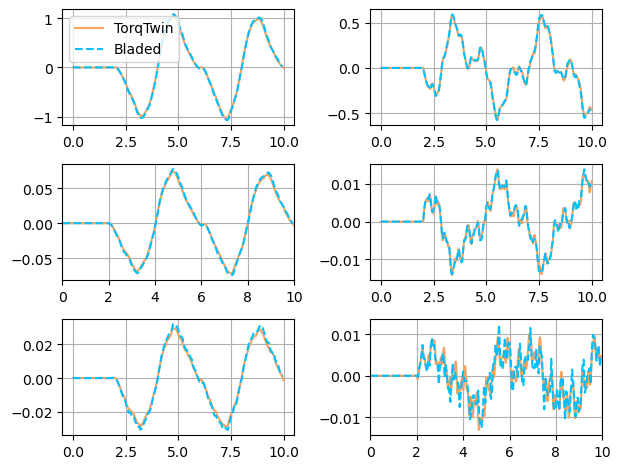

In [135]:
import matplotlib.pyplot as plt

xmax = 10 

plt.subplot(3, 2, 1)
plt.plot(tsim.transpose()[0],Def_dx, linestyle='-',color='sandybrown', label='TorqTwin')
plt.plot(BladedData['time'], BladedData['B1def'][0][:], linestyle='--', color='deepskyblue', label='Bladed')
plt.legend()
plt.grid(True)


plt.subplot(3, 2, 2)
plt.plot(tsim.transpose()[0],Def_dy, linestyle='-',color='sandybrown', label='TorqTwin')
plt.plot(BladedData['time'], BladedData['B1def'][1][:], linestyle='--', color='deepskyblue', label='Bladed')
#plt.legend()
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(tsim.transpose()[0],Def_dz, linestyle='-',color='sandybrown', label='TorqTwin')
plt.plot(BladedData['time'], BladedData['B1def'][2][:], linestyle='--', color='deepskyblue', label='Bladed')
#plt.legend()
plt.xlim(0,xmax)
# plt.title('q1')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(tsim.transpose()[0],Def_rx, linestyle='-',color='sandybrown', label='TorqTwin')
plt.plot(BladedData['time'], BladedData['B1def'][3][:], linestyle='--', color='deepskyblue', label='Bladed')
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(tsim.transpose()[0],Def_ry, linestyle='-',color='sandybrown', label='TorqTwin')
plt.plot(BladedData['time'], BladedData['B1def'][4][:], linestyle='--', color='deepskyblue', label='Bladed')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(tsim.transpose()[0],Def_rz, linestyle='-',color='sandybrown', label='TorqTwin')
plt.plot(BladedData['time'], BladedData['B1def'][5][:], linestyle='--', color='deepskyblue', label='Bladed')
#plt.legend()
plt.xlim(0,xmax)
# plt.title('q1')
plt.grid(True)



plt.tight_layout()